https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Stationarity

In [2]:
airpassengers = pd.read_csv('../datasets/AirPassengers.csv')

airpassengers_ts = pd.Series(airpassengers['#Passengers'].values, 
                            index = pd.date_range('1949-01', periods = len(airpassengers), freq='M'))

Text(0.5, 1.0, 'airpassengers')

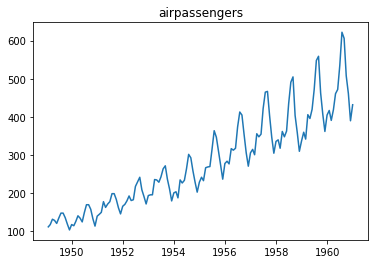

In [3]:
plt.plot(airpassengers_ts)
plt.title('airpassengers')

There are many techniques (logarithm, exponential, de-trending, differencing) can be use to transform non-stationary series into stationary.

what technique to use depend on the pattern of our time series

Since we has a series with increment variance, logarithm transformation can be use to smooth out the variance.

In [4]:
airpassengers_log = np.log(airpassengers_ts)

Text(0.5, 1.0, 'log transformation')

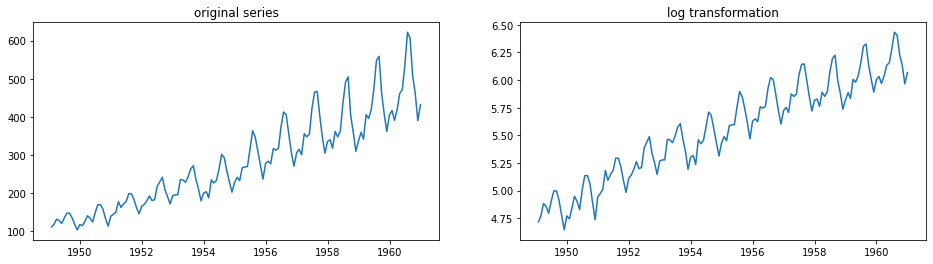

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_ts)
ax1.set_title('original series')

ax2.plot(airpassengers_log)
ax2.set_title('log transformation')

differencing

In [6]:
airpassengers_diff = airpassengers_log.diff()

Text(0.5, 1.0, 'differencing')

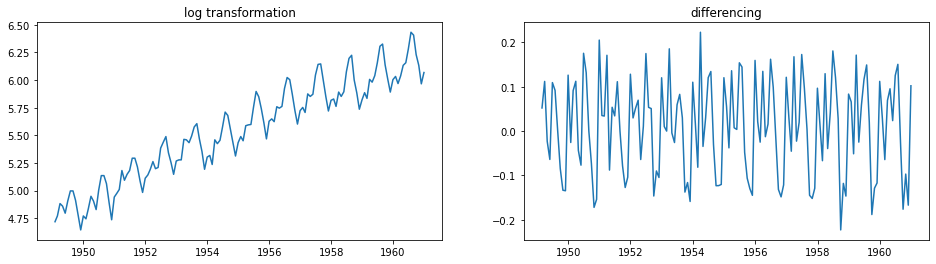

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_log)
ax1.set_title('log transformation')

ax2.plot(airpassengers_diff)
ax2.set_title('differencing')

### Stationarity Check

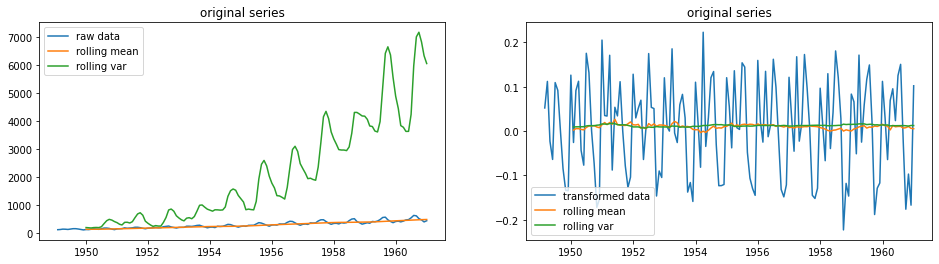

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_ts, label = 'raw data')
ax1.plot(airpassengers_ts.rolling(window=12).mean(), label="rolling mean");
ax1.plot(airpassengers_ts.rolling(window=12).var(), label="rolling var");
ax1.set_title('original series')
ax1.legend()

ax2.plot(airpassengers_diff, label = 'transformed data')
ax2.plot(airpassengers_diff.rolling(window=12).mean(), label="rolling mean");
ax2.plot(airpassengers_diff.rolling(window=12).var(), label="rolling var");
ax2.set_title('original series')
ax2.legend()

#### Augmented Dickey-Fuller Test (ADF)

ADF is a type of unit root test. Unit roots are a cause for non-stationarity, the ADF test will test if unit root is present.

A time series is stationary if a single shift in time doesn’t change the time series statistical properties, in which case unit root does not exist.

The Null and Alternate hypothesis of the Augmented Dickey-Fuller test is defined as follows:
- Null Hypothesis states there is the presence of a unit root.
- Alternate Hypothesis states there is no unit root. In other words, Stationarity exists.


The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
root, with the alternative that there is no unit root. If the pvalue is
above a critical size, then we cannot reject that there is a unit root.

https://machinelearningmastery.com/time-series-data-stationary-python/

http://www.insightsbot.com/augmented-dickey-fuller-test-in-python/

In [9]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(airpassengers_ts, maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        1.564685
P-Value                   0.997748
# Lags Used              12.000000
# Observations Used     131.000000
Critical Value (1%)      -3.481282
Critical Value (5%)      -2.883868
Critical Value (10%)     -2.578677
dtype: float64


In [11]:
result = adfuller(airpassengers_diff[1:], maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.053032
P-Value                   0.030230
# Lags Used              12.000000
# Observations Used     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


#### Test Stationary using Autocorrelation Function (ACF)

http://rstudio-pubs-static.s3.amazonaws.com/311446_08b00d63cc794e158b1f4763eb70d43a.html

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.graphics.gofplots import qqplot
# from scipy.stats import probplot

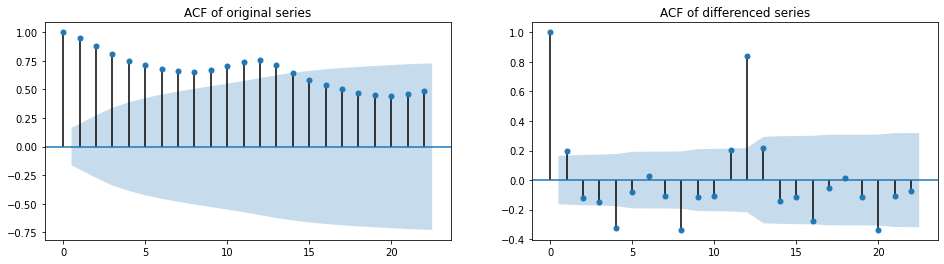

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

plot_acf(airpassengers_ts, ax1)
ax1.set_title('ACF of original series')

plot_acf(airpassengers_diff[1:], ax2)
ax2.set_title('ACF of differenced series')

plt.show()

### Simple Forecasting

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

airpassengers_ts_train = airpassengers_ts[:-24]
airpassengers_ts_test = airpassengers_ts[-24:]

airpassengers_log_train = airpassengers_log[:-24]
airpassengers_log_test = airpassengers_log[-24:]

airpassengers_diff_train = airpassengers_diff[:-24]
airpassengers_diff_test = airpassengers_diff[-24:]

ses = SimpleExpSmoothing(airpassengers_diff_train[1:])
ses = ses.fit()

ses_forecast = ses.forecast(24)

Text(0.5, 1.0, 'forecast for next 24 month')

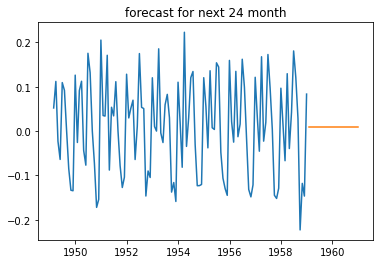

In [15]:
plt.plot(airpassengers_diff_train)
plt.plot(ses_forecast)
plt.title('forecast for next 24 month')

inverse differencing

In [16]:
ses_forecast[0] = ses_forecast[0] + airpassengers_log_train[-1]
ses_forecast_inv_diff = ses_forecast.cumsum()

inverse log transformation

In [17]:
ses_forecast_inv_log = np.exp(ses_forecast_inv_diff)

Text(0.5, 1.0, 'inverse log transformation')

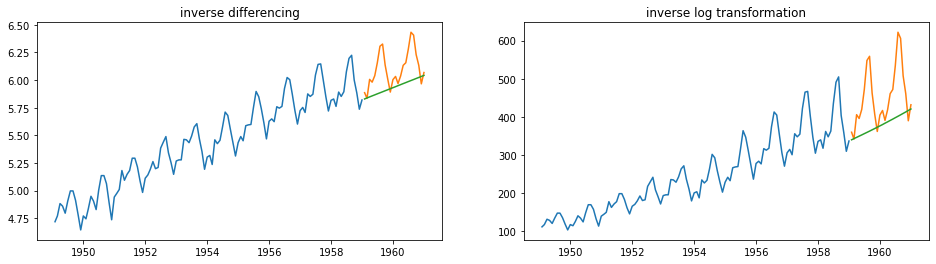

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(airpassengers_log_train)
ax1.plot(airpassengers_log_test)
ax1.plot(ses_forecast_inv_diff)
ax1.set_title('inverse differencing')

ax2.plot(airpassengers_ts_train)
ax2.plot(airpassengers_ts_test)
ax2.plot(ses_forecast_inv_log)
ax2.set_title('inverse log transformation')

# ARIMA

ARIMA is stand for Autoregressive Integrated Moving Average. The integrated refers to differencing hence it allow the model to support series with trend.

ARIMA expects data that is either not seasonal or has the seasonal component removed, thus we can perform seasonal differencing to eliminate the seasonality in the data.

In [19]:
from statsmodels.tsa.arima_model import ARIMA

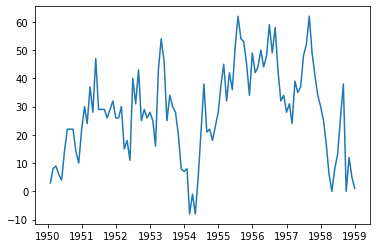

In [20]:
airpassengers_season_diff_train = airpassengers_ts_train.diff(12)

plt.plot(airpassengers_season_diff_train)

In [21]:
arima = ARIMA(airpassengers_season_diff_train.dropna(), order=(4,0,1)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                     ARMA(4, 1)   Log Likelihood                -399.378
Method:                       css-mle   S.D. of innovations              9.715
Date:                Tue, 24 Mar 2020   AIC                            812.756
Time:                        12:58:05   BIC                            831.531
Sample:                    01-31-1950   HQIC                           820.368
                         - 12-31-1958                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.6613      5.614      4.571      0.000      14.658      36.665
ar.L1.y        1.0792      0.684      1.579      0.114      -0.261       2.419
ar.L2.y       -0.0444      0.489     -0.091      0.928      -1.003       0.915
ar.L3.y       -0.2515      0.199     -1.262      0.207      -0.642       0.139
ar.L4.y        0.1140      0.113      1.007      0.314      -0.108       0.336
ma.L1.y       -0.3756      0.684     -0.549      0.583      -1.717       0.966
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9001           -0.0000j            1.9001           -0.5000
AR.2            1.1511           -0.0000j            1.1511           -0.0000
AR.3            1.4776           -1.3520j            2.0028           -0.1179
AR.4            1.4776           +1.3520j            2.0028            0.1179
MA.1            2.6621           +0.0000j            2.6621            0.0000
-----------------------------------------------------------------------------
"""

The values under *coef* are the weights of the respective terms. 

AIC and BIC is to tell how good is the model and can be use to compare with other models. The lower the AIC the better the model



#### Residuals

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:
- The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
- The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.
- The residuals have constant variance.
- The residuals are normally distributed.


Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

In [83]:
residuals = pd.Series(arima.resid)

In [120]:
import seaborn as sns

def check_residuals(series):
    fig = plt.figure(figsize=(16, 8))    
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(series)
    ax1.set_title('residuals')
    
    ax2 = fig.add_subplot(gs[1,0])
    plot_acf(series, ax=ax2, title='ACF')
    
    ax3 = fig.add_subplot(gs[1,1])
    sns.kdeplot(series, ax=ax3)
    ax3.set_title('density')
    
    plt.show()

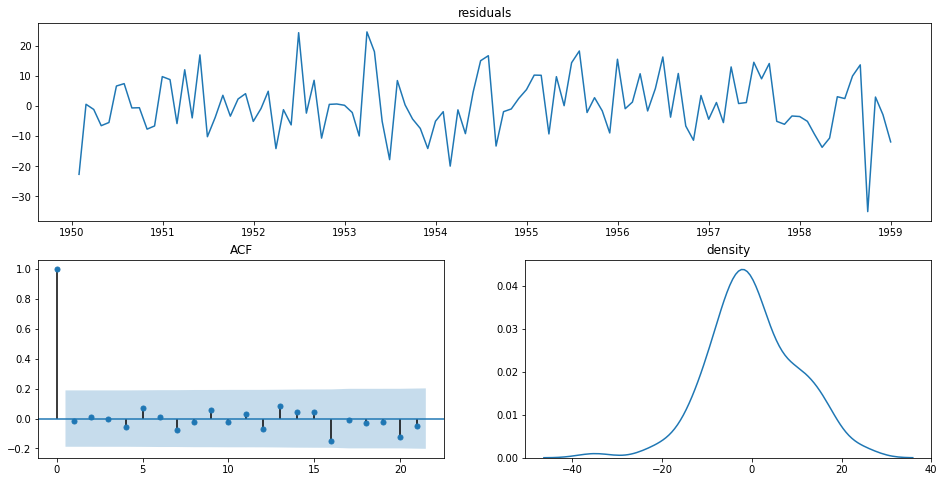

In [121]:
check_residuals(residuals)

In [38]:
arima_forecast, se, conf = arima.forecast(24)

arima_forecast = pd.Series(arima_forecast, index=airpassengers_ts_test.index)
lower_series = pd.Series(conf[:, 0], index=airpassengers_ts_test.index)
upper_series = pd.Series(conf[:, 1], index=airpassengers_ts_test.index)

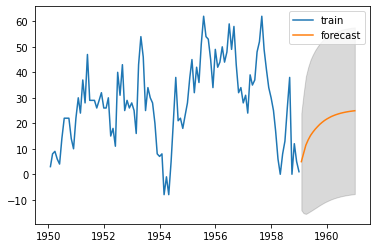

In [59]:
plt.plot(airpassengers_season_diff_train, label='train')
plt.plot(arima_forecast, label='forecast')

plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.legend()

In [52]:
def inverse_differencing(orig_data, diff_data, interval):
    output = orig_data[:interval].tolist()
    for i in range(interval, len(diff_data)):
        output.append(output[i-interval] + diff_data[i])
    return output

In [55]:
airpassengers_season_diff_train_forecast = airpassengers_season_diff_train.append(arima_forecast)
airpassengers_season_diff_train_upper = airpassengers_season_diff_train.append(upper_series)
airpassengers_season_diff_train_lower = airpassengers_season_diff_train.append(lower_series)
    
airpassengers_forecast = inverse_differencing(airpassengers_ts_train, airpassengers_season_diff_train_forecast, 12)
airpassengers_lower = inverse_differencing(airpassengers_ts_train, airpassengers_season_diff_train_lower, 12)
airpassengers_upper = inverse_differencing(airpassengers_ts_train, airpassengers_season_diff_train_upper, 12)

airpassengers_forecast_series = pd.Series(airpassengers_forecast, index=airpassengers_season_diff_train_forecast.index)
airpassengers_lower_series = pd.Series(airpassengers_lower, index=airpassengers_season_diff_train_forecast.index)
airpassengers_upper_series = pd.Series(airpassengers_upper, index=airpassengers_season_diff_train_forecast.index)


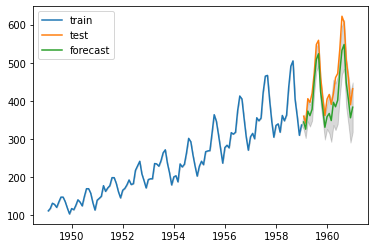

In [57]:
plt.plot(airpassengers_forecast_series[:-24], label = 'train')
plt.plot(airpassengers_ts_test, label = 'test')
plt.plot(airpassengers_forecast_series[-24:], label = 'forecast')

plt.fill_between(airpassengers_lower_series.index, airpassengers_lower_series, 
                 airpassengers_upper_series, color='k', alpha=.15)
plt.legend()


In [34]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(airpassengers_ts_test, output_ts[-24:])
print('Test MSE: ', mse)

Test MSE:  2240.845318701566


## SARIMA

Seasonal Autoregressive Integrated Moving Average (SARIMA) ia a method to forecast univariate time series with trend and seasonality.

In [125]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [151]:
sarimax = SARIMAX(airpassengers_ts_train, order=(3,1,1), seasonal_order=(0,1,0,12)).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  120
Model:             SARIMAX(3, 1, 1)x(0, 1, [], 12)   Log Likelihood                -397.385
Date:                             Tue, 24 Mar 2020   AIC                            804.771
Time:                                     17:23:51   BIC                            818.135
Sample:                                 01-31-1949   HQIC                           810.188
                                      - 12-31-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5364      0.202      2.651      0.008       0.140       0.933
ar.L2          0.1857      0.145      1.277      0.202      -0.099       0.471
ar.L3         -0.1562      0.145     -1.074      0.283      -0.441       0.129
ma.L1         -0.7948      0.234     -3.400      0.001      -1.253      -0.337
sigma2        98.2491     13.823      7.107      0.000      71.156     125.342
===================================================================================
Ljung-Box (Q):                       35.87   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.66   Prob(JB):                         0.28
Heteroskedasticity (H):               1.53   Skew:                            -0.09
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [152]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  120
Model:             SARIMAX(3, 1, 1)x(0, 1, [], 12)   Log Likelihood                -397.385
Date:                             Tue, 24 Mar 2020   AIC                            804.771
Time:                                     17:23:51   BIC                            818.135
Sample:                                 01-31-1949   HQIC                           810.188
                                      - 12-31-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5364      0.202      2.651      0.008       0.140       0.933
ar.L2          0.1857      0.145      1.277      0.202      -0.099       0.471
ar.L3         -0.1562      0.145     -1.074      0.283      -0.441       0.129
ma.L1         -0.7948      0.234     -3.400      0.001      -1.253      -0.337
sigma2        98.2491     13.823      7.107      0.000      71.156     125.342
===================================================================================
Ljung-Box (Q):                       35.87   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.66   Prob(JB):                         0.28
Heteroskedasticity (H):               1.53   Skew:                            -0.09
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

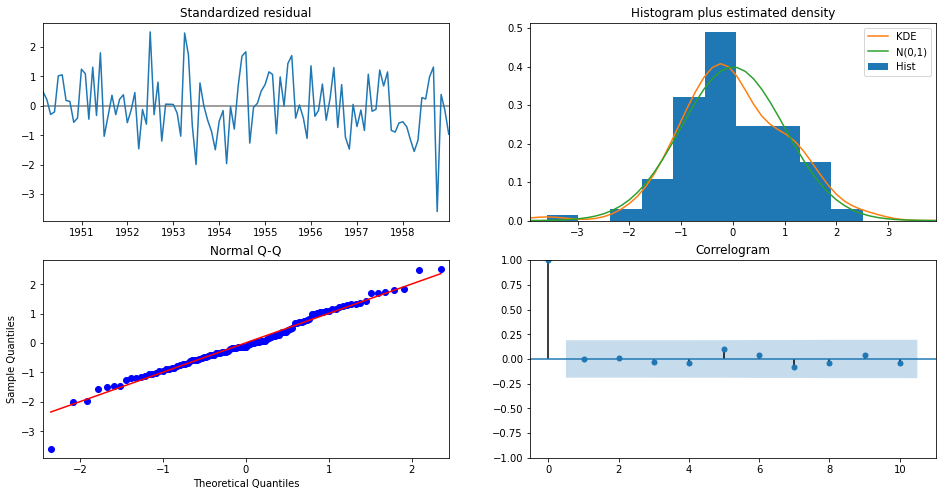

In [153]:
sarimax.plot_diagnostics(figsize=(16, 8))
plt.show()

In [192]:
sarimax_forecast = sarimax.get_forecast(24)
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

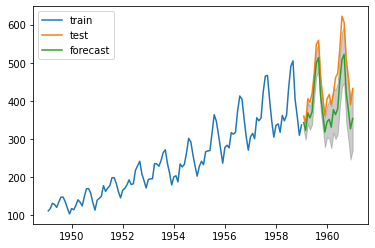

In [193]:
plt.plot(airpassengers_ts_train, label='train')
plt.plot(airpassengers_ts_test, label='test')
plt.plot(sarimax_forecast.predicted_mean, label='forecast')


plt.fill_between(sarimax_forecast_conf_int.index,
                 sarimax_forecast_conf_int.iloc[:, 0],
                 sarimax_forecast_conf_int.iloc[:, 1], color='k', alpha=.2)

plt.legend()


In [37]:
arima2 = ARIMA(airpassengers_ts_train, order=(6,1,3)).fit()
arima2.summary()

C:\Users\willi\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\willi\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\willi\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\willi\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\willi\AppData\Local\Continuum\miniconda3\envs\main\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid valu

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  119
Model:                 ARIMA(6, 1, 3)   Log Likelihood                -532.376
Method:                       css-mle   S.D. of innovations             20.425
Date:                Tue, 24 Mar 2020   AIC                           1086.752
Time:                        11:17:42   BIC                           1117.322
Sample:                    02-28-1949   HQIC                          1099.166
                         - 12-31-1958                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4943      0.194     12.854      0.000       2.114       2.875
ar.L1.D.y      0.6385      0.093      6.839      0.000       0.455       0.821
ar.L2.D.y     -0.9280      0.106     -8.749      0.000      -1.136      -0.720
ar.L3.D.y      0.7341      0.123      5.967      0.000       0.493       0.975
ar.L4.D.y     -0.6446      0.127     -5.083      0.000      -0.893      -0.396
ar.L5.D.y      0.2137      0.111      1.930      0.054      -0.003       0.431
ar.L6.D.y     -0.3367      0.093     -3.602      0.000      -0.520      -0.153
ma.L1.D.y     -0.5467      0.052    -10.494      0.000      -0.649      -0.445
ma.L2.D.y      0.6088        nan        nan        nan         nan         nan
ma.L3.D.y     -0.9559        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9465           -0.6476j            1.1469           -0.0955
AR.2            0.9465           +0.6476j            1.1469            0.0955
AR.3           -0.6397           -1.0770j            1.2526           -0.3353
AR.4           -0.6397           +1.0770j            1.2526            0.3353
AR.5            0.0105           -1.1997j            1.1997           -0.2486
AR.6            0.0105           +1.1997j            1.1997            0.2486
MA.1           -0.2046           -0.9788j            1.0000           -0.2828
MA.2           -0.2046           +0.9788j            1.0000            0.2828
MA.3            1.0461           -0.0000j            1.0461           -0.0000
-----------------------------------------------------------------------------
"""

In [38]:
arima_forecast_raw2 = arima2.forecast(24)
arima_forecast2 = pd.Series(arima_forecast_raw2[0], index=airpassengers_ts_test.index)

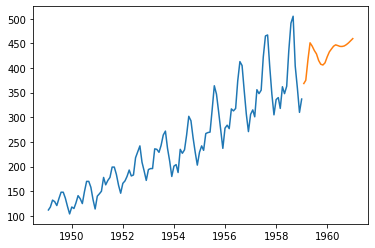

In [39]:
plt.plot(airpassengers_ts_train)
plt.plot(arima_forecast2)

In [470]:
len(output)

120

In [ ]:
def inverse_differencing(diff_series, interval, prev_series):
    

In [95]:
airpassengers_diff_train = airpassengers_diff[:-24]
airpassengers_diff_test = airpassengers_diff[-24:]

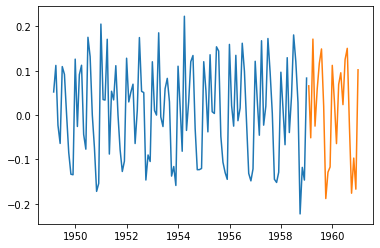

In [96]:
plt.plot(airpassengers_diff_train)
plt.plot(airpassengers_diff_test)

In [210]:
arima = ARIMA(airpassengers_diff[1:], order=(11,0,1)).fit()

/home/william/miniconda3/envs/main/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/william/miniconda3/envs/main/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [211]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  143
Model:                    ARMA(11, 1)   Log Likelihood                 226.623
Method:                       css-mle   S.D. of innovations              0.046
Date:                Mon, 23 Mar 2020   AIC                           -425.246
Time:                        12:18:30   BIC                           -383.766
Sample:                    02-28-1949   HQIC                          -408.391
                         - 12-31-1960                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.001     17.318      0.000       0.009       0.011
ar.L1.y       -0.8414      0.077    -10.973      0.000      -0.992      -0.691
ar.L2.y       -0.8027      0.060    -13.295      0.000      -0.921      -0.684
ar.L3.y       -0.7977      0.068    -11.667      0.000      -0.932      -0.664
ar.L4.y       -0.8734      0.051    -17.260      0.000      -0.973      -0.774
ar.L5.y       -0.7968      0.075    -10.626      0.000      -0.944      -0.650
ar.L6.y       -0.8036      0.067    -12.041      0.000      -0.934      -0.673
ar.L7.y       -0.7955      0.067    -11.949      0.000      -0.926      -0.665
ar.L8.y       -0.9114      0.045    -20.136      0.000      -1.000      -0.823
ar.L9.y       -0.8139      0.068    -12.002      0.000      -0.947      -0.681
ar.L10.y      -0.8382      0.059    -14.132      0.000      -0.954      -0.722
ar.L11.y      -0.7620      0.060    -12.705      0.000      -0.880      -0.644
ma.L1.y        0.4368      0.078      5.625      0.000       0.285       0.589
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.8698           -0.4940j            1.0003           -0.0822
AR.2             0.8698           +0.4940j            1.0003            0.0822
AR.3             0.5066           -0.8737j            1.0100           -0.1664
AR.4             0.5066           +0.8737j            1.0100            0.1664
AR.5             0.0201           -1.0434j            1.0436           -0.2469
AR.6             0.0201           +1.0434j            1.0436            0.2469
AR.7            -0.5111           -0.8818j            1.0192           -0.3336
AR.8            -0.5111           +0.8818j            1.0192            0.3336
AR.9            -0.8923           -0.5002j            1.0230           -0.4187
AR.10           -0.8923           +0.5002j            1.0230            0.4187
AR.11           -1.0861           -0.0000j            1.0861           -0.5000
MA.1            -2.2893           +0.0000j            2.2893            0.5000
------------------------------------------------------------------------------
"""

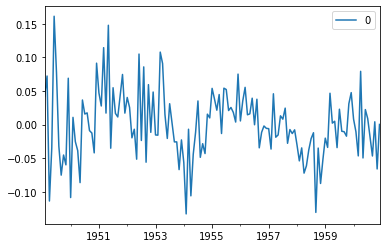

In [212]:
residuals = pd.DataFrame(arima.resid)
residuals.plot()

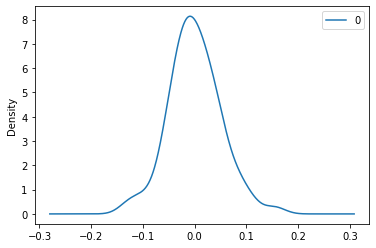

In [213]:
residuals.plot(kind='kde')

In [214]:
arima_forecast_raw = arima.forecast(24)
arima_forecast_ts = pd.Series(arima_forecast_raw[0], index=airpassengers_diff_test.index)

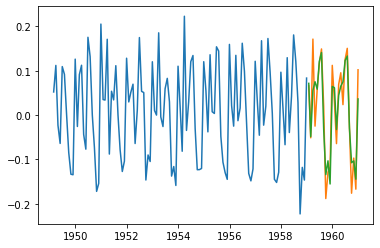

In [215]:
plt.plot(airpassengers_diff_train)
plt.plot(airpassengers_diff_test)
plt.plot(arima_forecast_ts)

In [216]:
arima_forecast_ts[0] = airpassengers_log[-25]
arima_forecast_inv_diff = arima_forecast_ts.cumsum()

arima_forecast_inv_log = np.exp(arima_forecast_inv_diff)

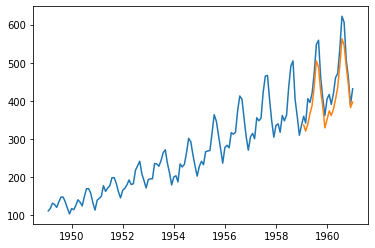

In [217]:
plt.plot(airpassengers_ts)
plt.plot(arima_forecast_inv_log)

In [218]:
arima_forecast_raw

(array([ 5.82008293, -0.04867971,  0.05593923,  0.07528109,  0.05836079,
         0.12121914,  0.14124727, -0.03221469, -0.1345278 , -0.10323068,
        -0.15555659,  0.06487121,  0.06157364, -0.03263792,  0.04445361,
         0.06525104,  0.07514499,  0.12292097,  0.13336191, -0.02950241,
        -0.10755893, -0.10347767, -0.14480499,  0.03639949]),
 array([0.04629104, 0.04993627, 0.05432766, 0.05446664, 0.05469971,
        0.05483891, 0.05483963, 0.0548438 , 0.05510508, 0.05532953,
        0.05533089, 0.055391  , 0.06573802, 0.06679119, 0.06873658,
        0.06903713, 0.06940664, 0.06952414, 0.06953402, 0.06954794,
        0.06996788, 0.07025787, 0.07026966, 0.07042241]),
 array([[-0.0191137 ,  0.16234385],
        [-0.146553  ,  0.04919357],
        [-0.05054102,  0.16241947],
        [-0.03147157,  0.18203375],
        [-0.04884866,  0.16557024],
        [ 0.01373685,  0.22870143],
        [ 0.03376358,  0.24873096],
        [-0.13970656,  0.07527718],
        [-0.24253177, -0.026

In [115]:
airpassengers_log

1949-01-31    4.718499
1949-02-28    4.770685
1949-03-31    4.882802
1949-04-30    4.859812
1949-05-31    4.795791
                ...   
1960-08-31    6.406880
1960-09-30    6.230481
1960-10-31    6.133398
1960-11-30    5.966147
1960-12-31    6.068426
Freq: M, Length: 144, dtype: float64

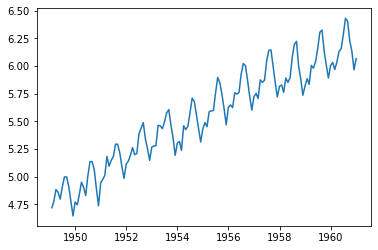

In [116]:
plt.plot(airpassengers_log)

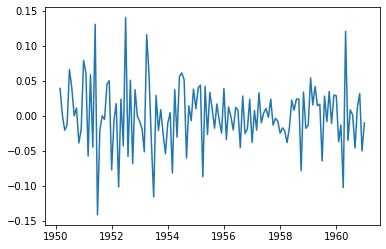

In [120]:
plt.plot(airpassengers_log.diff(periods=12).diff(periods=1))

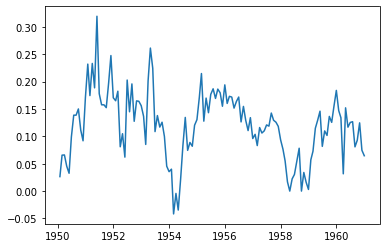

In [121]:
plt.plot(airpassengers_log.diff(periods=12))

In [122]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 